# Plot Variance of Variables to Study Origins of Variability

## Install Necessary Python Packages and `PyHarm`

NOTE: ONLY NEED TO RUN THIS ONCE TO SETUP YOUR PYTHON ENVIRONMENT.

Uncomment the following cell to run.

It will install the python packages as user.  Library will be placed in ~/.local/lib/python3.8/site-packages

You may need to restart Jupyter notebook.

In [1]:
! pip3 install -U pip
! module load hdf5 && pip3 install -U numpy==1.23 h5py nbconvert toolz
! pip3 install https://github.com/AFD-Illinois/pyharm/archive/refs/heads/master.zip

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 7.2.10
    Uninstalling nbconvert-7.2.10:
      Successfully uninstalled nbconvert-7.2.10
Defaulting to user installation because normal site-packages is not writeable
     - 1.1 MB 3.2 MB/s 0:00:000m0m
  Preparing metadata (setup.py) ... done


  Created wheel for pyharm: filename=pyharm-2022.8-py3-none-any.whl size=159675 sha256=93fdd0df767ecf150c591f43b03c7645c8aad4efc1e8ef82549c24742b1fb556
  Stored in directory: /tmp/pip-ephem-wheel-cache-7vwpkc3k/wheels/08/a8/8c/041e429127d4a02c446c47ce359b830ff607210713d99f9ae7
Successfully built pyharm
  Attempting uninstall: pyharm
    Found existing installation: pyharm 2022.8
    Uninstalling pyharm-2022.8:
      Successfully uninstalled pyharm-2022.8


## Set up This Notebook

In [2]:
# Useful tricks for development
%load_ext autoreload
%autoreload 2

In [3]:
# Load packages

from toolz import valmap

import h5py
import pyharm

from matplotlib   import pyplot as plt
from pyharm.plots import plot_dumps as pplt

## Settings We Will Use

In [4]:
i0 = 5990 # initial  frame
i1 = 6000 # 1 + last frame

src = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

## File Name and Corrupted File...

In [5]:
def fname(i): # closure on `src` and `fmt`
    return (src+fmt).format(i)

/home/u12/limengjiang/.local/lib/python3.8/site-packages/pyharm/variables.py:96: RuntimeWarning: invalid value encountered in divide
  'Theta': lambda dump: (dump['gam'] - 1) * dump['UU'] / dump['RHO'],


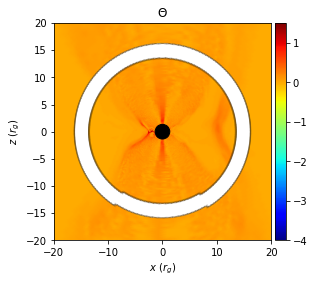

In [6]:
# Oops... frame 5006 is corrupted

dump = pyharm.load_dump(fname(5006))
fig, ax = plt.subplots(1,1)
pplt.plot_xz(ax, dump, 'Theta', vmin=-4, vmax=1.5, window=(-20,20,-20,20)) # dump['gam']: number density? why is there a subtraction? fluctuation?

## Define a Function to Average Over Multiple Keys and Run the 1st Pass

In [7]:
import numpy as np

In [8]:
def average(irange, keys):
    s = {k:0 for k in keys}
    for i in irange:
        print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = pyharm.load_dump(fname(i))
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [9]:
qualities_new = ['rho', 'Pg', 'bsq', 'beta', 'Theta']
# cache_avg = average(range(i0,i1), qualities)
cache_avg = average(range(i0,i1), qualities)

i: 5990
i: 5991
i: 5992
i: 5993
i: 5994
i: 5995
i: 5996
i: 5997
i: 5998
i: 5999


## Define a Function to Compute the Variances and Run the 2nd Pass

In [10]:
def variance(irange, avgs):
    ss = {k:0 for k in avgs}
    for i in irange:
        print(i)
        # Because data I/O is expensive, we load the data once ...
        d = pyharm.load_dump(fname(i))
        # ... and then sum over multiple keys
        for k, v in avgs.items():
            ss[k] += (d[k]-v)**2
    return valmap(lambda v: v/len(irange), ss)

In [11]:
cache_var = variance(range(i0,i1), cache_avg)

5990
5991
5992
5993
5994
5995
5996
5997
5998
5999


## Plot the Averages and Variances

In [12]:
# To make the `pyHarm` plotting functions work, we need `Grid`, `FluidDump`, etc.
# The easily method is to load a `FluidDump` from a reference file,
# and then attach the computed arrays as cached values.

dump = pyharm.load_dump(fname(i0))
# ? dump.cache
for k, v in cache_avg.items():
    dump.cache['avg'+k] = v
    
for k, v in cache_var.items():
    dump.cache['var'+k] = v

In [17]:
dump.cache.keys()

dict_keys(['avgRHO', 'avgPg', 'avgbsq', 'avgbeta', 'avgTheta', 'avgThetae', 'varRHO', 'varPg', 'varbsq', 'varbeta', 'varTheta', 'varThetae'])

In [13]:
# To help the visualization, let's plot the first and last frames

dump0 = pyharm.load_dump(fname(i0))
dump1 = pyharm.load_dump(fname(i1-1))

In [14]:
w = (-20,20,-20,20)
# are m and mm decided after a few attempts? yes
def mkplots(k, m, mm):
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    pplt.plot_xz(axes[0], dump0,      k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[1], dump1,      k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[2], dump, 'avg'+k, window=w, vmin=0, vmax=m)
    pplt.plot_xz(axes[3], dump, 'var'+k, window=w, vmin=0, vmax=mm)

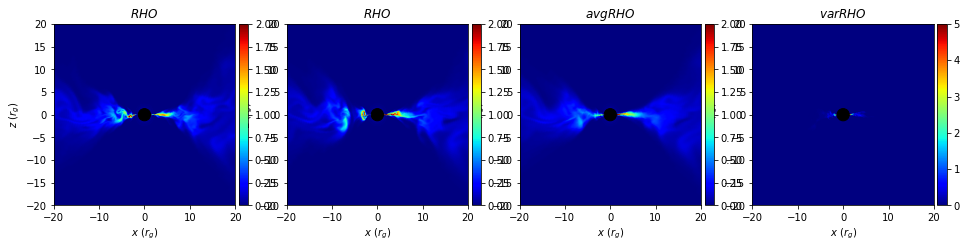

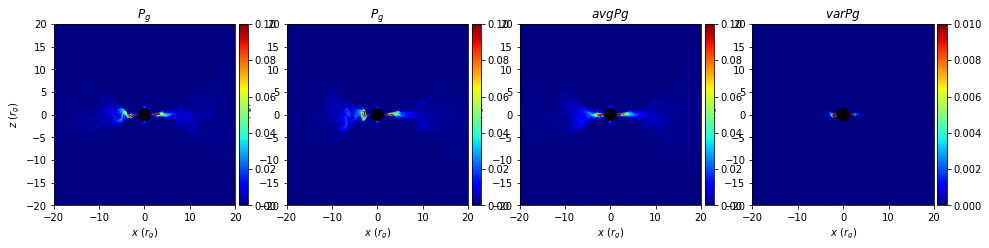

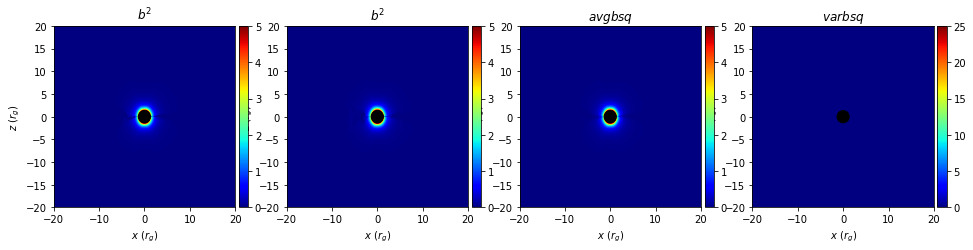

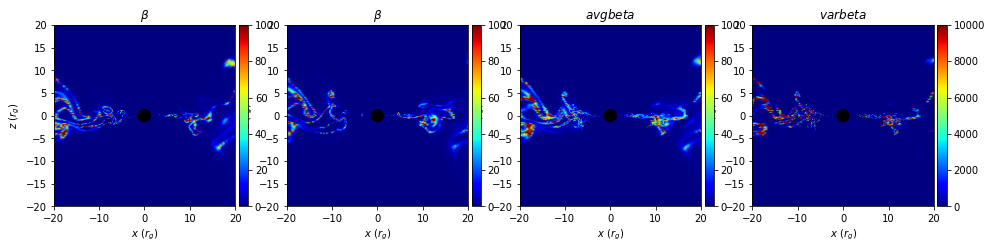

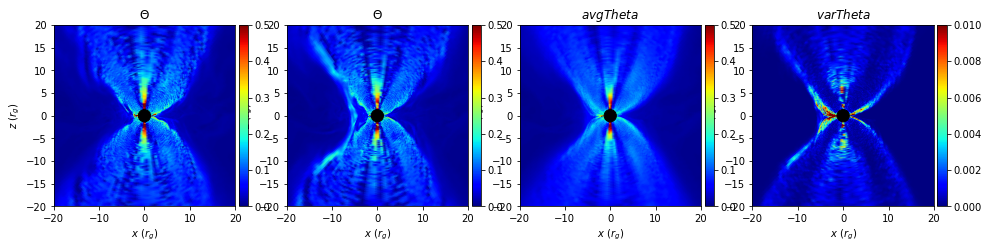

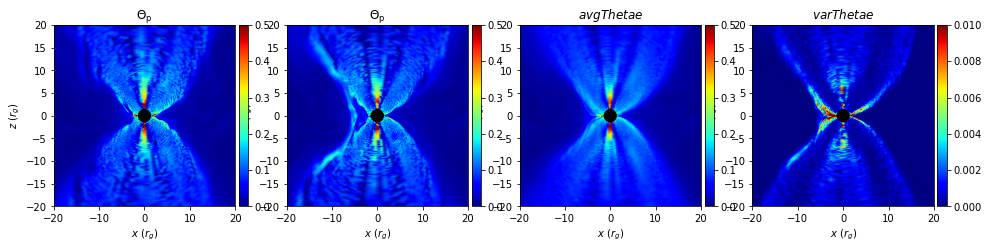

In [18]:
mkplots('RHO',    2,   5)
mkplots('Pg',     0.1, 0.01)
mkplots('bsq',    5,   25)
mkplots('beta',   100, 10000)
mkplots('Theta',  0.5, 0.01)
mkplots('Thetae', 0.5, 0.01)